# Prediction improvement

The aim of this notebook is to improve the predictions using image processing:
- We find clusters of points corresponding to roads using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) from the sklearn library.
- We fill the holes in roads using the `binary_fill_holes` procedure of scipy ([reference](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html)).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.cluster import DBSCAN

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from src.path import DATA_TEST_IMG_PATH, DEFAULT_SUBMISSION_MASK_DIR

In [3]:
# Get filenames
images = [f'test_{i + 1}/test_{i + 1}.png' for i in range(50)]
predictions = sorted(os.listdir(DEFAULT_SUBMISSION_MASK_DIR))

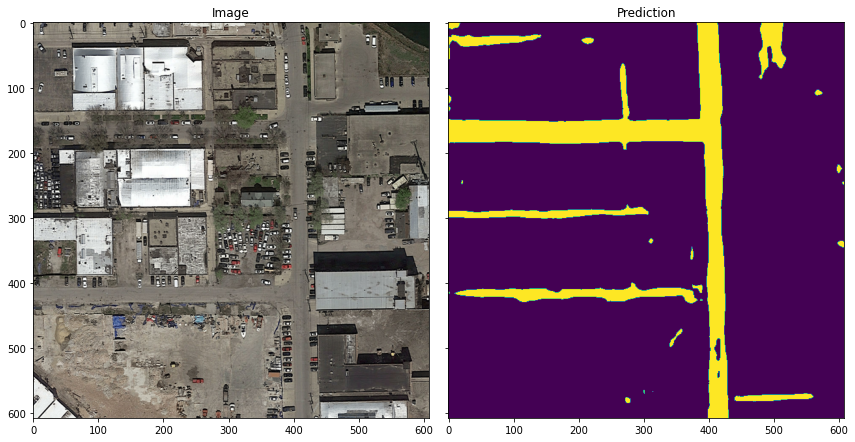

In [4]:
# Show image and prediction
index = 11
image = Image.open(os.path.join(DATA_TEST_IMG_PATH, images[index]))
pred = Image.open(os.path.join(DEFAULT_SUBMISSION_MASK_DIR, predictions[index]))
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(pred)
ax[1].set_title('Prediction')
fig.tight_layout()

In [5]:
# Convert prediction to array
pred_array = np.array(pred)
pred_array.shape, pred_array.dtype

((608, 608), dtype('uint8'))

In [6]:
# Transform to an array of points
x_arr, y_arr = np.where(pred_array > 0)
X = np.array([[x, y] for x, y in zip(x_arr, y_arr)])
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [607, 428],
       [607, 429],
       [607, 430]])

- Number of clusters: 17
- Points per cluster: Counter({1: 37031, 9: 3101, 2: 2203, 0: 1891, 13: 142, 3: 140, 5: 80, 11: 77, 4: 73, 6: 70, 12: 66, 15: 60, 10: 39, 7: 13, 8: 11, 14: 10, -1: 1})
- Clusters to keep: [0, 1, 2, 9]


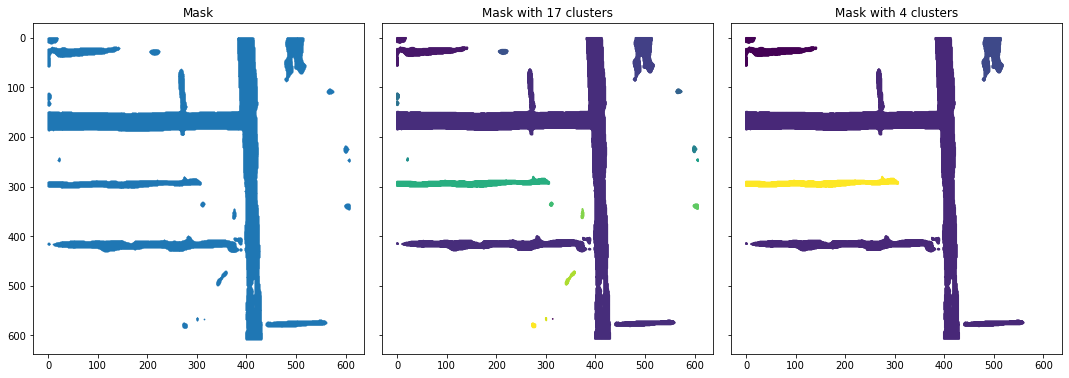

In [7]:
EPS = 10  # maximum distance between two samples of a cluster
MIN_NB_POINTS = 1000  # minimum number of points to keep a cluster

# Clustering
dbscan = DBSCAN(eps=EPS)
labels = dbscan.fit_predict(X)
n_clusters = len(set(labels))
print('- Number of clusters:', n_clusters)

# Count number of points per cluster
points_per_cluster = Counter(labels)
print('- Points per cluster:', points_per_cluster)

# Drop small clusters
cluster_to_keep = [
    i for i in points_per_cluster if points_per_cluster[i] >= MIN_NB_POINTS
]
print('- Clusters to keep:', cluster_to_keep)
mask = np.isin(labels, cluster_to_keep)

# Plot clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].scatter(y_arr, x_arr, s=0.5).axes.invert_yaxis()
ax[0].set_aspect('equal', 'box')
ax[0].set_title('Mask')
ax[1].scatter(y_arr, x_arr, s=0.5, c=labels).axes.invert_yaxis()
ax[1].set_aspect('equal', 'box')
ax[1].set_title(f'Mask with {n_clusters} clusters')
ax[2].scatter(y_arr[mask], x_arr[mask], s=0.5, c=labels[mask]).axes.invert_yaxis()
ax[2].set_aspect('equal', 'box')
ax[2].set_title(f'Mask with {len(cluster_to_keep)} clusters')
fig.tight_layout()

In [8]:
# Create new prediction
new_pred_after_clustering_array = np.zeros_like(pred_array)
new_pred_after_clustering_array[x_arr[mask], y_arr[mask]] = 255
new_pred_after_clustering_array

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [9]:
# Fill holes
new_pred_array = np.array(
    binary_fill_holes(new_pred_after_clustering_array), dtype=np.uint8) * 255
new_pred_array

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

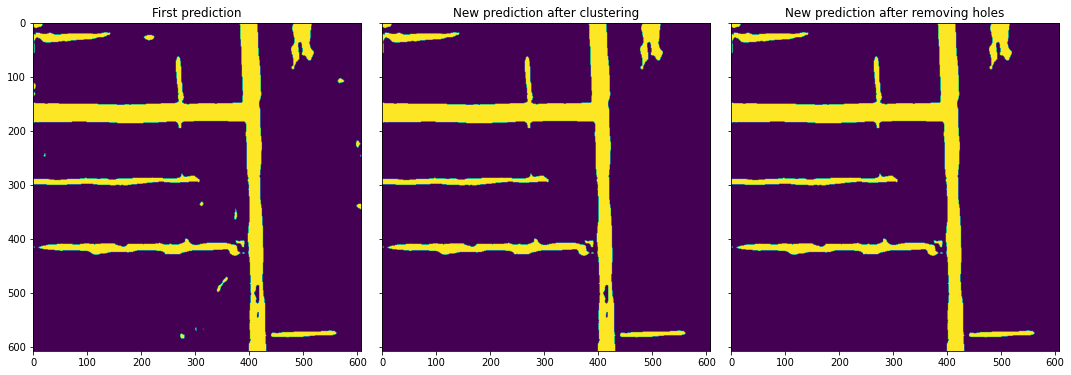

In [10]:
# Compare predictions
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].imshow(pred)
ax[0].set_title('First prediction')
ax[1].imshow(new_pred_after_clustering_array)
ax[1].set_title('New prediction after clustering')
ax[2].imshow(new_pred_array)
ax[2].set_title('New prediction after removing holes')
fig.tight_layout()

## Conclusion

In [11]:
EPS = 10  # maximum distance between two samples of a cluster
MIN_NB_POINTS = 1000  # minimum number of points to keep a cluster


def get_cleaned_pred(pred_array: np.ndarray) -> np.ndarray:
    """Cleans a prediction by removing small clusters and filling holes.

    Args:
        pred_array (np.ndarray): prediction of type numpy array.

    Returns:
        np.ndarray: cleaned prediction.
    """
    # Transform prediction to an array of points
    x_arr, y_arr = np.where(pred_array > 0)
    X = np.array([[x, y] for x, y in zip(x_arr, y_arr)])

    # Clustering
    dbscan = DBSCAN(eps=EPS)
    labels = dbscan.fit_predict(X)

    # Count number of points per cluster
    points_per_cluster = Counter(labels)

    # Drop small clusters
    cluster_to_keep = [
        i for i in points_per_cluster if points_per_cluster[i] >= MIN_NB_POINTS
    ]
    mask = np.isin(labels, cluster_to_keep)

    # Create new prediction with removed small clusters
    new_pred_array = np.zeros_like(pred_array)
    new_pred_array[x_arr[mask], y_arr[mask]] = 255

    # Fill holes
    new_pred_array = np.array(
        binary_fill_holes(new_pred_array),
        dtype=np.uint8,
    ) * 255

    return new_pred_array

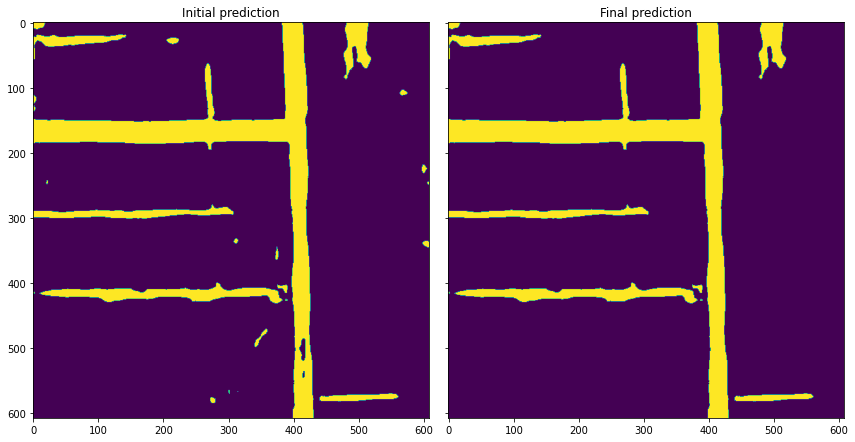

In [12]:
# New function in action
pred_array = np.array(pred)
new_pred_array = get_cleaned_pred(pred_array)

# Compare predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax[0].imshow(pred_array)
ax[0].set_title('Initial prediction')
ax[1].imshow(new_pred_array)
ax[1].set_title('Final prediction')
fig.tight_layout()